# UNet training

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# we are using load_img available in keras directly
from tensorflow.keras.utils import load_img
from PIL.ImageOps import autocontrast
from skimage.util import img_as_int
from skimage.segmentation import relabel_sequential
from skimage.transform import rescale, resize, downscale_local_mean

from skimage.color import label2rgb
from skimage.morphology import label
from skimage.exposure import rescale_intensity
from skimage import io

from distinctipy import distinctipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd

# function that given an image path will plot the image. If a mask path is given as well, it will be printed
# if a model is given, it will predict the image with the given model and print it
def plot_segmentation(img_path, mask_path = None, model = None, reshape = False, path_internet = False,
                      figsize = [16, 4], cmap = plt.rcParams["image.cmap"]):
  plt.rcParams['figure.figsize'] = figsize

  # how many images are we plotting
  n = 1
  n += 2 if mask_path else 0
  n += 2 if model else 0
  fig, axes = plt.subplots(1, n)
  
  # read the image
  img  = io.imread(img_path)

  # resize the image to plot them with the same size
  if reshape:
    # resize the image to (160, 160)
    img = resize(img, img_size, anti_aliasing = True)

  # show original image
  axes[0].imshow(img)
  axes[0].set_title('Input Image')
  
  i = 1

  # we plot the target image if the image is not from the internet
  if not path_internet:
    labels = io.imread(mask_path) # we read image and only one channel, this is already the labels
    if reshape:
      # we reshape, since it is label data, we do not use anti aliasing and use nearest neighbors to avoid correctly 
      # resize the image
      labels = resize(labels, img_size, anti_aliasing = False, order = 0, preserve_range = True)

    colors_target = [colors[int(lab) - 1] for lab in np.unique(labels)[1:]]

    # plot the label image
    axes[1].imshow(label2rgb(labels, bg_label = 0, colors = colors_target))
    axes[1].set_title('Target Segmentation Mask')

    # target overlay on image
    axes[2].imshow(label2rgb(labels, img, bg_label = 0, colors = colors_target))
    axes[2].set_title('Target Overlay')

    # plot a legend on the bottom
    patches = [ mpatches.Patch(color=colors[int(lab) - 1], label = label_names['_name'][lab] ) for idx, lab in enumerate(np.unique(labels)[1:]) ]
    fig.legend(title = 'Target', handles=patches, loc='lower center', borderaxespad=0., 
                   ncol = len(np.unique(labels)) - 1, 
                   prop={'size': 10} )
    i += 2

  # if there is a model
  if model:
    if path_internet:
      mask_path = img_path
    # construct an image Generator
    gen_img = ImageGenerator(1, img_size, [img_path], [mask_path])

    # predict the image
    predicted_labels = model.predict(gen_img)[0]
    labels = np.argmax(predicted_labels, axis=-1)

    colors_predicted = [colors[int(lab) - 1] for lab in np.unique(labels)[1:]]


    # plot the predicted labels
    axes[i].imshow(label2rgb(labels, bg_label = 0, colors = colors_predicted))
    axes[i].set_title('Predicted Labels')
    
    i += 1
    
    # predicted labels overlayed on image
    axes[i].imshow(label2rgb(labels, image = resize(img, labels.shape), bg_label = 0, colors = colors_predicted))
    axes[i].set_title('Predicted Labels Overlayed')

    # plot a legend, depending on what we have plotted before we plot the legend in one positon or another
    patches_pred = [ mpatches.Patch(color=colors[int(lab) - 1], label = label_names['_name'][lab] ) for idx, lab in enumerate(np.unique(labels)[1:]) ]
    if i >= 3:
      fig.legend(title = 'Predicted', handles=patches_pred, loc='lower center', borderaxespad=0., 
                   ncol = len(np.unique(labels)) - 1, bbox_to_anchor=(0.495, 0.10),
                   prop={'size': 10} )
    else:
      fig.legend(title = 'Predicted', handles=patches_pred, borderaxespad=0., frameon = False,
              prop={'size': 10}, loc='center left', bbox_to_anchor=(1, 0.5) )

  # remove ticks
  for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.tight_layout()
  plt.show()

## Setting up global variables

In [2]:
root_path = ''
label_names = pd.read_csv(root_path + 'classes.csv')

# list of different colors, colors the same as classes, each class will have a unique color
colors = distinctipy.get_colors(26, rng = 12)

## Loading dataset

In [3]:
import os

train_img = 'XTrain' #os.path.join(root_path, 'XTrain')
train_mask = 'YTrain' #os.path.join(root_path, 'YTrain')
test_img = 'XTest' #os.path.join(root_path, 'XTest')
test_mask = 'YTest' #os.path.join(root_path, 'yTest')

In [4]:
img_size = (160, 160)   #Fix the size of all words
num_classes = 27  # fixed for this dataset
batch_size = 32

In [5]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".png") or fname.endswith(".png")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".png") or fname.endswith(".png")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 9000
Number of train masks: 9000
Number of test samples: 270
Number of test masks: 270


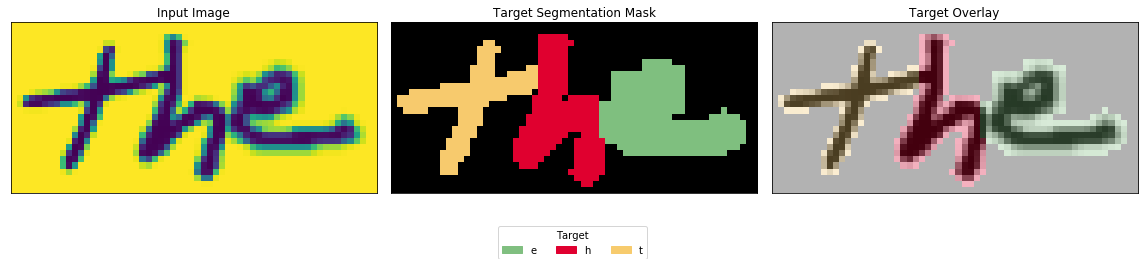

In [6]:
# the colors are always the same for the same label
plot_segmentation(train_img_paths[0], train_mask_paths[0], figsize = [16, 4])

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import load_img


class ImageGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, img_paths, mask_paths):
      # batch size
      self.batch_size = batch_size
      # image size
      self.img_size = img_size
      # image paths
      self.input_img_paths = img_paths
      # mask path
      self.target_img_paths = mask_paths
      # amount of images
      self.n_images = len(mask_paths)

    def __len__(self):
      # denotes the number of batches per epoch
      return self.n_images // self.batch_size

    def __getitem__(self, idx):
      """Returns tuple (input, target) correspond to batch #idx."""
      i = idx * self.batch_size
      batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
      batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
      x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
      for j, path in enumerate(batch_input_img_paths):
          img = load_img(path, target_size=self.img_size)
          x[j] = img
      y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
      for j, path in enumerate(batch_target_img_paths):
          img = load_img(path, target_size=self.img_size, color_mode="grayscale")
          y[j] = np.expand_dims(img, 2)
      return x, y

In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )

        drop = layers.SpatialDropout2D(0.2)(x)

        x = layers.add([x, residual, drop])  # Add back residual and dropout
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        drop = layers.SpatialDropout2D(0.2)(x)

        x = layers.add([x, residual, drop])  # Add back residual and dropout
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [9]:
# Free up RAM in case the model definition cells were run multiple times

import keras
keras.backend.clear_session()

In [10]:
# Build model

model = get_model(img_size, num_classes)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [12]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = keras.callbacks.ModelCheckpoint("emnist.h5", save_best_only=True, monitor = ['accuracy', 'loss', 'val_accuracy', 'val_loss'])

#### Train the model

In [13]:
# Train the model, doing validation at the end of each epoch.
epochs = 20
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
281/281 [==============================] - 50s 131ms/step - loss: 1.3132 - val_loss: 4.0324
Epoch 2/20
281/281 [==============================] - 35s 125ms/step - loss: 0.3423 - val_loss: 0.4191
Epoch 3/20
281/281 [==============================] - 35s 125ms/step - loss: 0.2471 - val_loss: 0.4649
Epoch 4/20
281/281 [==============================] - 35s 125ms/step - loss: 0.2028 - val_loss: 0.4452
Epoch 5/20
281/281 [==============================] - 35s 125ms/step - loss: 0.1772 - val_loss: 0.5517
Epoch 6/20
281/281 [==============================] - 35s 125ms/step - loss: 0.1620 - val_loss: 0.4114
Epoch 7/20
281/281 [==============================] - 35s 125ms/step - loss: 0.1484 - val_loss: 0.2507
Epoch 8/20
281/281 [==============================] - 36s 126ms/step - loss: 0.1367 - val_loss: 0.2941
Epoch 9/20
281/281 [==============================] - 35s 125ms/step - loss: 0.1277 - val_loss: 0.3331
Epoch 10/20
281/281 [==============================] - 35s 125ms/step - l

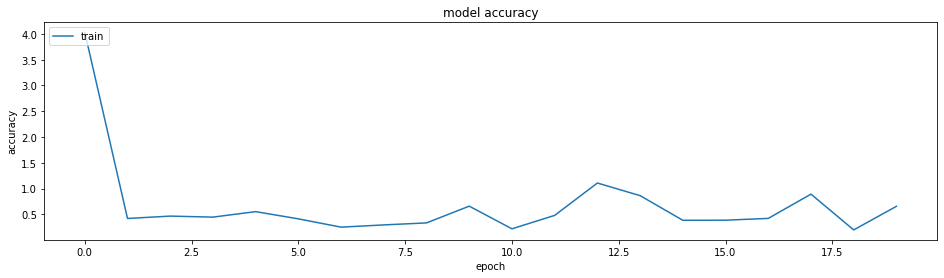

In [25]:
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
batch_size = 1  # we define batch_size as 1 for inferencing
val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [27]:
# solution
val_preds = model.predict(val_gen)

270/270 [==============================] - 1s 4ms/step


In [28]:
predicted_mask = np.argmax(val_preds, axis=-1)

In [29]:
masks = []
from skimage.color import rgb2gray
for path in test_mask_paths:
  img = io.imread(path) # read image and get only one channel info
  masks.append(img)

1/1 [==============================] - 0s 27ms/step


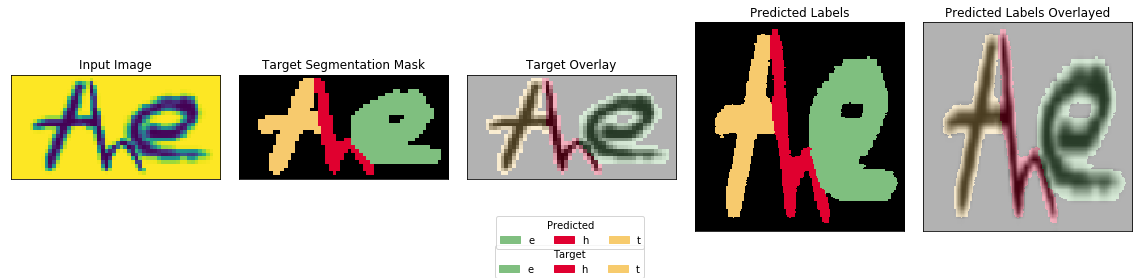

In [30]:
plot_segmentation(train_img_paths[0], train_mask_paths[0], figsize = [16, 4], model = model)

Now observe the results with the best model

1/1 [==============================] - 0s 27ms/step


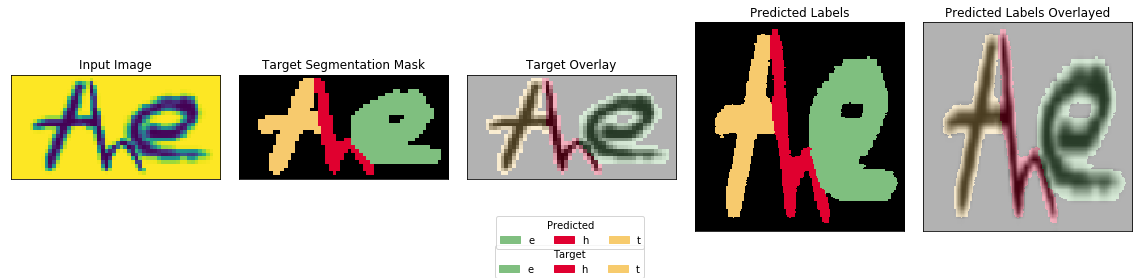

In [31]:
model.load_weights("emnist.h5")

plot_segmentation(train_img_paths[0], train_mask_paths[0], figsize = [16, 4], model = model)

### Improving result by manually selecting what classes to find

In [32]:
val_preds = model.predict(val_gen)

270/270 [==============================] - 1s 3ms/step


In [33]:
letter_indexes = [0,5,8,20]

In [34]:
predicted_mask = np.argmax(val_preds[:,:,:,letter_indexes], axis=-1)

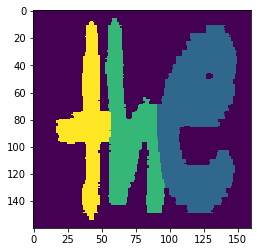

In [35]:
plt.imshow(predicted_mask[0,:,:])